# AFL Time Series Data

In [2]:
# We begin by importing dependencies and setting the random seed for reproducibility

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.ticker as ticker

np.random.seed(42)

In [3]:
# We load the cleaned data file created by scraping the AFL stats site footywire.com.au

df = pd.read_csv('../data/full_data.csv')
# Betting data only goes back to 2010, so dropping earlier years for consistency
df = (df[(df['year'] >= 2010)]
        # Note that bye weeks and seasons before newer teams existed mark most stats as 0,
        # including the opposing team's name
        .assign(draw=((df['score'] == df['oppo_score']) & (df['oppo_team'] != '0')).astype('int'))
        .fillna(0)
        .set_index(['team', 'year', 'round_number'], drop=False)
        .sort_index())

df

home_team  last_finals_reached  \
team             year round_number                                   
Adelaide         2010 1                   0.0                  2.0   
                      2                   1.0                  2.0   
                      3                   0.0                  2.0   
                      4                   1.0                  2.0   
                      5                   0.0                  2.0   
                      6                   1.0                  2.0   
                      7                   1.0                  2.0   
                      8                   0.0                  2.0   
                      9                   1.0                  2.0   
                      10                  0.0                  2.0   
                      11                  1.0                  2.0   
                      12                  0.0                  2.0   
                      13                  1.0                  2.0   
                      14                  1.0                  2.0   
                      15                  0.0                  2.0   
                      16                  1.0                  2.0   
                      17                  0.0                  2.0   
                      18                  0.0                  2.0   
                      19                  1.0                  2.0   
                      20                  0.0                  2.0   
                      21                  0.0                  2.0   
                      22                  1.0                  2.0   
                      23                  0.0                  0.0   
                      24                  0.0                  0.0   
                 2011 1                   1.0                  0.0   
                      2                   0.0                  0.0   
                      3                   1.0                  0.0   
                      4                   0.0                  0.0   
                      5                   0.0                  0.0   
                      6                   1.0                  0.0   
...                                       ...                  ...   
Western Bulldogs 2016 19                  0.0                  1.0   
                      20                  1.0                  1.0   
                      21                  1.0                  1.0   
                      22                  0.0                  1.0   
                      23                  0.0                  1.0   
                      24                  0.0                  0.0   
                 2017 1                   0.0                  4.0   
                      2                   1.0                  4.0   
                      3                   0.0                  4.0   
                      4                   0.0                  4.0   
                      5                   1.0                  4.0   
                      6                   0.0                  4.0   
                      7                   1.0                  4.0   
                      8                   0.0                  4.0   
                      9                   0.0                  4.0   
                      10                  1.0                  4.0   
                      11                  0.0                  0.0   
                      12                  0.0                  4.0   
                      13                  1.0                  4.0   
                      14                  1.0                  4.0   
                      15                  1.0                  4.0   
                      16                  0.0                  4.0   
                      17                  0.0                  4.0   
                      18                  1.0                  4.0   
                      19                  1.0 

In [4]:
# Some useful functions

# Common column calculation across heuristics
def correct_tip(df):
    # Draws give all tippers a win
    return ((df['win'] == df['pred_win']) | (df['draw'] == 1)).astype('int')

# Negative point spread indicates the favourite
def betting_pred_win(df):
    # point_spread == 0 means it's a coin flip
    return (((df['point_spread'] < 0) | ((df['point_spread'] == 0) & (np.random.rand() >= 0.5)))
            .astype('int'))
    
def point_spread_predictions(df):
    return df['point_spread'].apply(point_spread_prediction)

In [5]:
# Creating betting DF with betting-odds predictions

betting_df = df[df['oppo_team'] != '0'].assign(pred_win=betting_pred_win)
betting_df.loc[:, 'correct_pred'] = correct_tip(betting_df)
betting_df.loc[:, 'pred_diff'] = (betting_df['pred_win'] - betting_df['win']).astype('int')

team_list = betting_df['team'].drop_duplicates()

betting_df

home_team  last_finals_reached  \
team             year round_number                                   
Adelaide         2010 1                   0.0                  2.0   
                      2                   1.0                  2.0   
                      3                   0.0                  2.0   
                      4                   1.0                  2.0   
                      5                   0.0                  2.0   
                      6                   1.0                  2.0   
                      7                   1.0                  2.0   
                      8                   0.0                  2.0   
                      9                   1.0                  2.0   
                      10                  0.0                  2.0   
                      11                  1.0                  2.0   
                      12                  0.0                  2.0   
                      13                  1.0                  2.0   
                      14                  1.0                  2.0   
                      15                  0.0                  2.0   
                      16                  1.0                  2.0   
                      17                  0.0                  2.0   
                      18                  0.0                  2.0   
                      19                  1.0                  2.0   
                      20                  0.0                  2.0   
                      21                  0.0                  2.0   
                      22                  1.0                  2.0   
                 2011 1                   1.0                  0.0   
                      3                   1.0                  0.0   
                      4                   0.0                  0.0   
                      5                   0.0                  0.0   
                      6                   1.0                  0.0   
                      7                   0.0                  0.0   
                      8                   1.0                  0.0   
                      9                   0.0                  0.0   
...                                       ...                  ...   
Western Bulldogs 2016 16                  1.0                  1.0   
                      17                  1.0                  1.0   
                      18                  1.0                  1.0   
                      19                  0.0                  1.0   
                      20                  1.0                  1.0   
                      21                  1.0                  1.0   
                      22                  0.0                  1.0   
                      23                  0.0                  1.0   
                 2017 1                   0.0                  4.0   
                      2                   1.0                  4.0   
                      3                   0.0                  4.0   
                      4                   0.0                  4.0   
                      5                   1.0                  4.0   
                      6                   0.0                  4.0   
                      7                   1.0                  4.0   
                      8                   0.0                  4.0   
                      9                   0.0                  4.0   
                      10                  1.0                  4.0   
                      12                  0.0                  4.0   
                      13                  1.0                  4.0   
                      14                  1.0                  4.0   
                      15                  1.0                  4.0   
                      16                  0.0                  4.0   
                      17                  0.0                  4.0   
                      18                  1.0 

## Betting odds per team over time

In [35]:
# Create df with rolling mean columns (with a 23 round window):
# mean win rate, mean predicted win rate (per betting odds), mean betting odds accuracy,
# and mean difference between win rate and predicted win rate

rolling_23 = (betting_df.groupby(level=0)
                        [['win', 'pred_win', 'correct_pred', 'pred_diff']]
                        # Use 23 rounds for window to get balance between charts that are too choppy
                        # and rolling means that change too slowly
                        .rolling(window=23)
                        .mean()
                        .rename(columns={'win': 'rolling_win_rate_23',
                                         'pred_win': 'rolling_pred_win_rate_23',
                                         'correct_pred': 'rolling_accuracy_23',
                                         'pred_diff': 'rolling_pred_diff_23'}))
rolling_23.index = rolling_23.index.droplevel()
rolling_23.loc[:, 'rolling_abs_pred_diff_23'] = rolling_23['rolling_pred_diff_23'].apply(abs)

rolling_df = (pd.concat([betting_df, rolling_23], axis=1)
                .dropna()
                .assign(score_diff=lambda x: x['score'] - x['oppo_score']))
rolling_df

home_team  last_finals_reached  \
team             year round_number                                   
Adelaide         2011 1                   1.0                  0.0   
                      3                   1.0                  0.0   
                      4                   0.0                  0.0   
                      5                   0.0                  0.0   
                      6                   1.0                  0.0   
                      7                   0.0                  0.0   
                      8                   1.0                  0.0   
                      9                   0.0                  0.0   
                      10                  1.0                  0.0   
                      11                  0.0                  0.0   
                      12                  1.0                  0.0   
                      13                  0.0                  0.0   
                      14                  0.0                  0.0   
                      15                  1.0                  0.0   
                      17                  1.0                  0.0   
                      18                  0.0                  0.0   
                      19                  1.0                  0.0   
                      20                  0.0                  0.0   
                      21                  1.0                  0.0   
                      22                  0.0                  0.0   
                      23                  1.0                  0.0   
                      24                  0.0                  0.0   
                 2012 1                   0.0                  0.0   
                      2                   1.0                  0.0   
                      3                   0.0                  0.0   
                      4                   1.0                  0.0   
                      5                   1.0                  0.0   
                      6                   0.0                  0.0   
                      7                   1.0                  0.0   
                      8                   0.0                  0.0   
...                                       ...                  ...   
Western Bulldogs 2016 16                  1.0                  1.0   
                      17                  1.0                  1.0   
                      18                  1.0                  1.0   
                      19                  0.0                  1.0   
                      20                  1.0                  1.0   
                      21                  1.0                  1.0   
                      22                  0.0                  1.0   
                      23                  0.0                  1.0   
                 2017 1                   0.0                  4.0   
                      2                   1.0                  4.0   
                      3                   0.0                  4.0   
                      4                   0.0                  4.0   
                      5                   1.0                  4.0   
                      6                   0.0                  4.0   
                      7                   1.0                  4.0   
                      8                   0.0                  4.0   
                      9                   0.0                  4.0   
                      10                  1.0                  4.0   
                      12                  0.0                  4.0   
                      13                  1.0                  4.0   
                      14                  1.0                  4.0   
                      15                  1.0                  4.0   
                      16                  0.0                  4.0   
                      17                  0.0                  4.0   
                      18                  1.0 

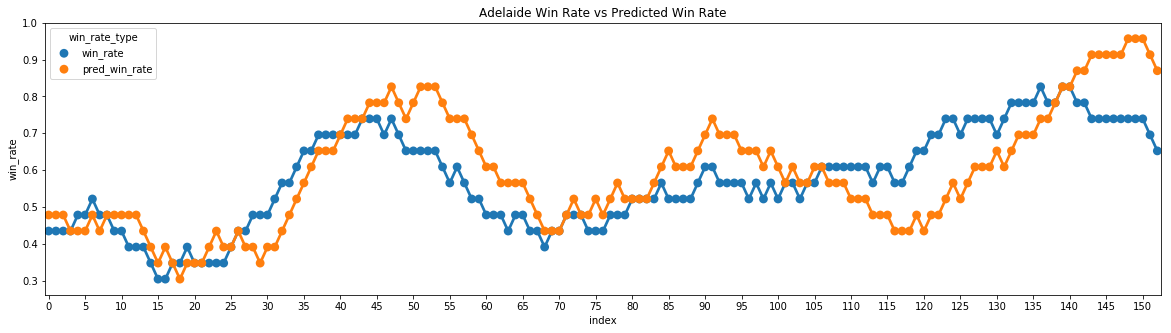

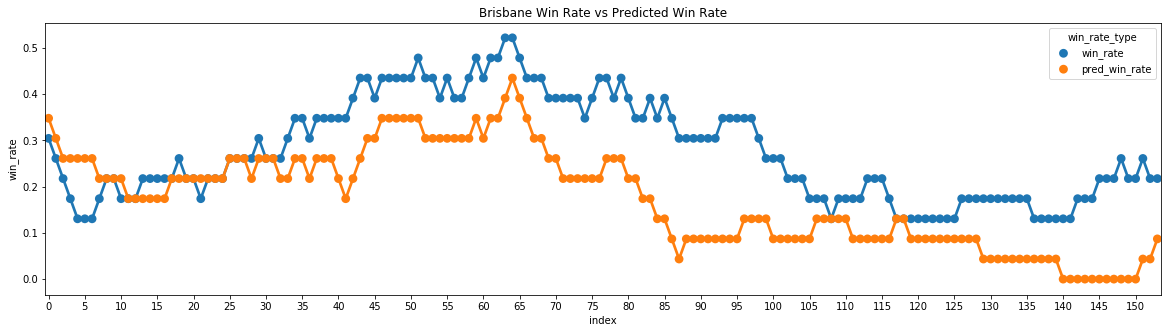

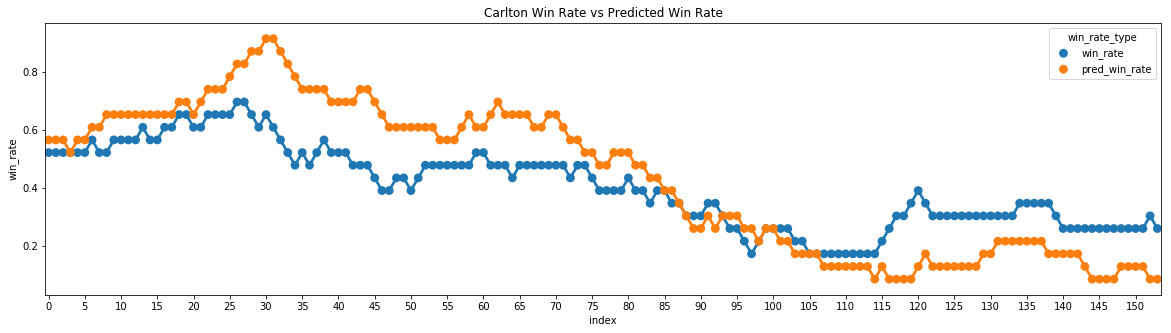

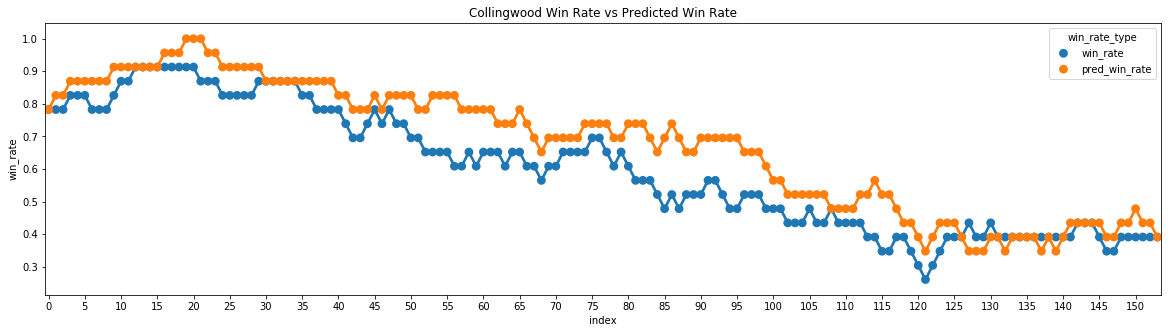

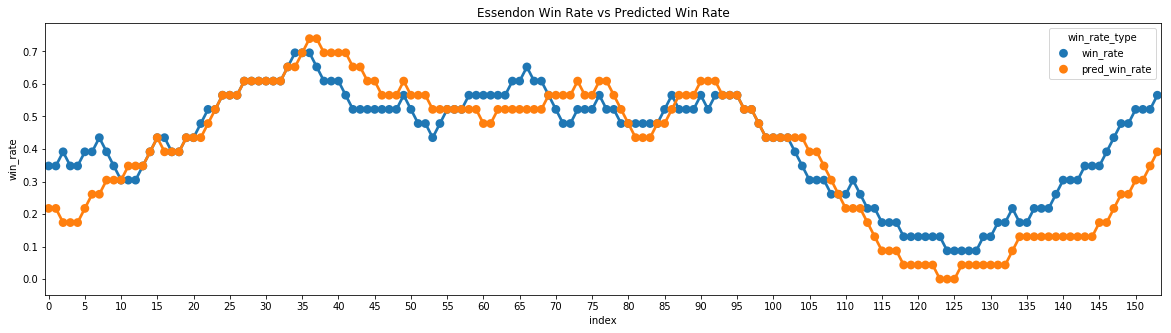

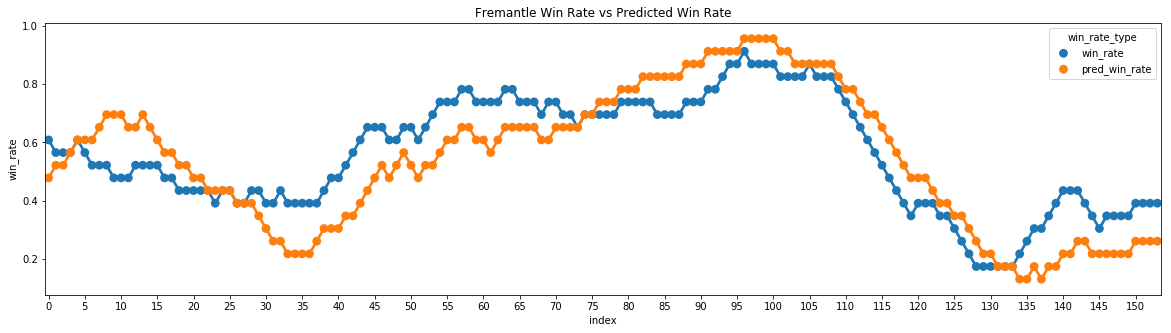

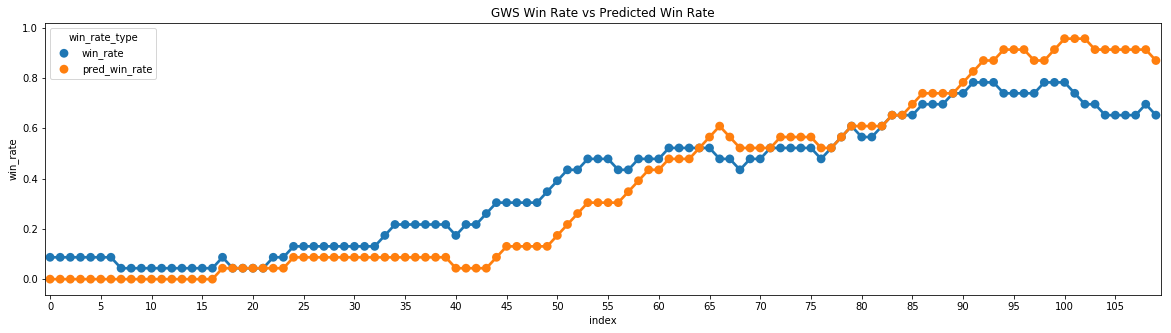

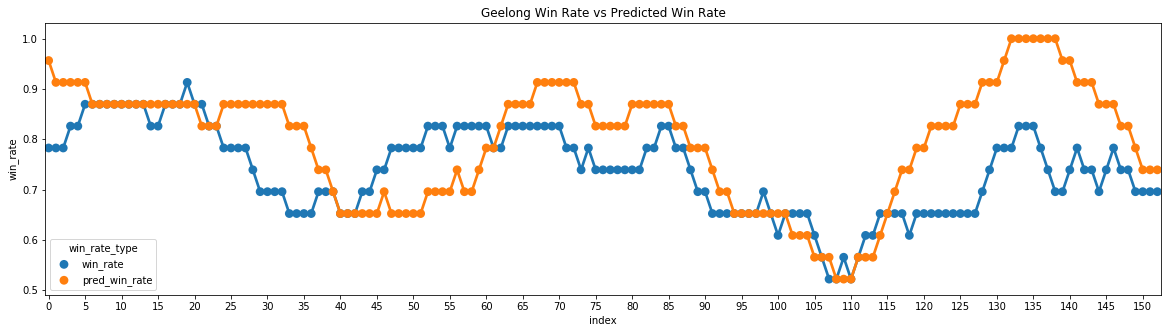

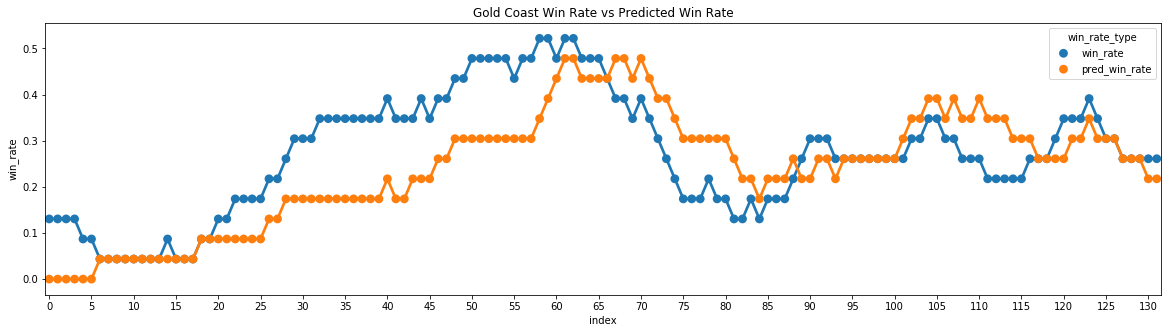

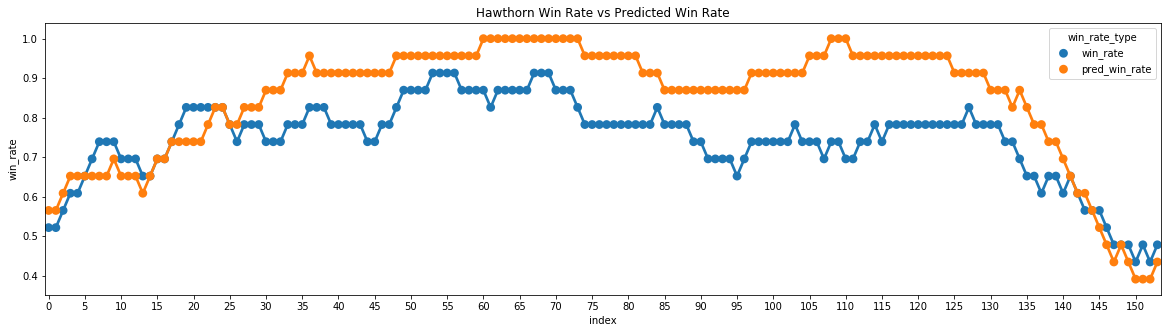

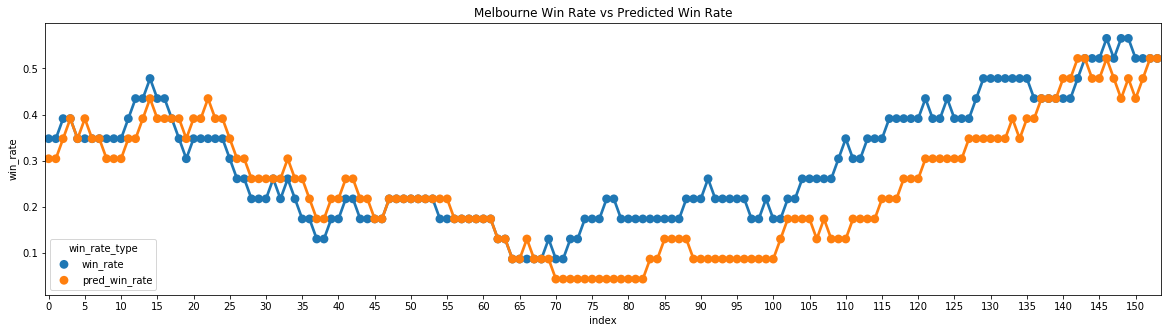

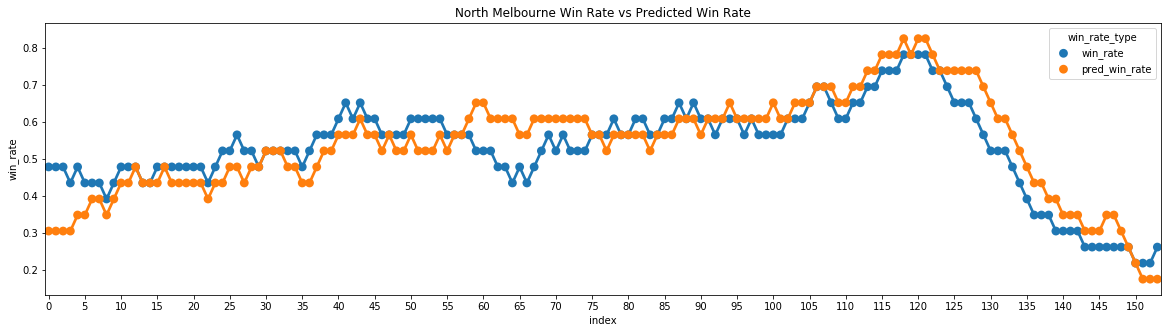

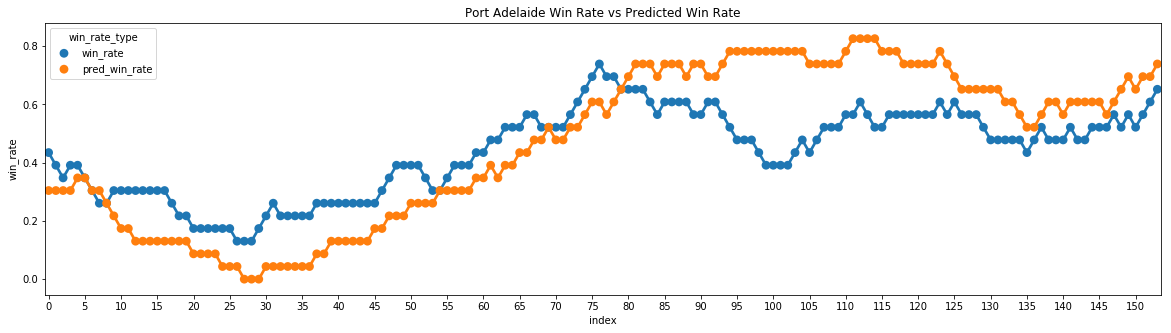

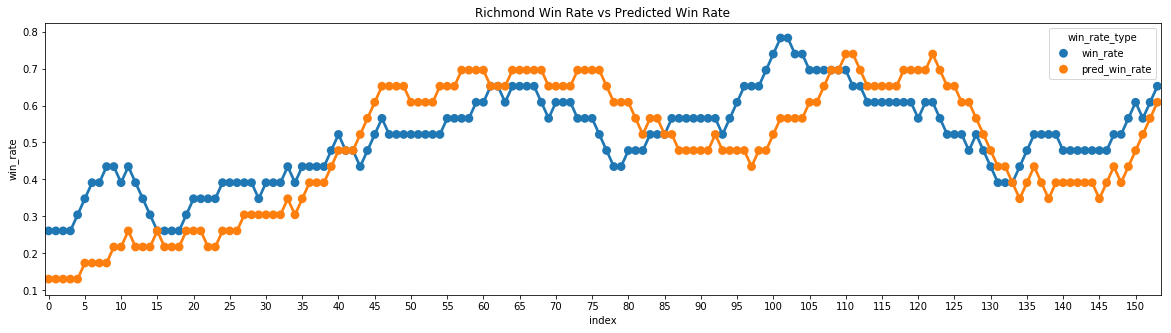

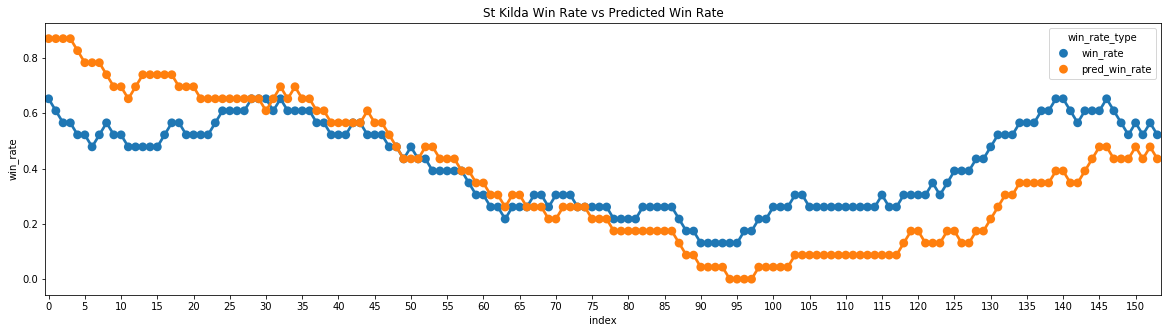

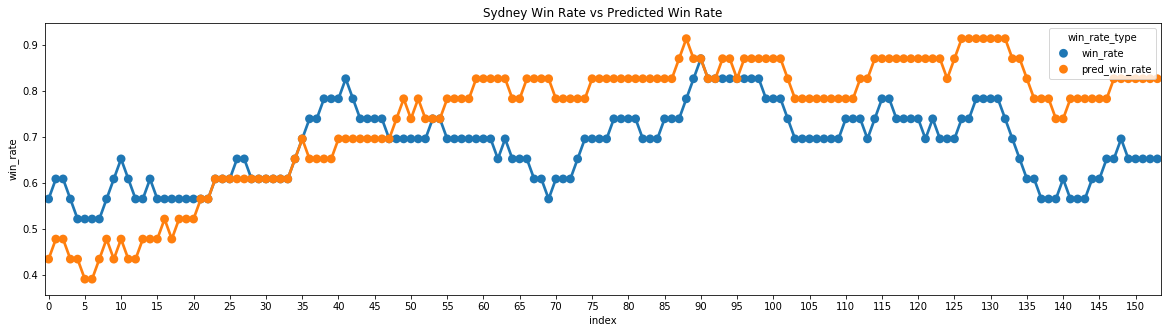

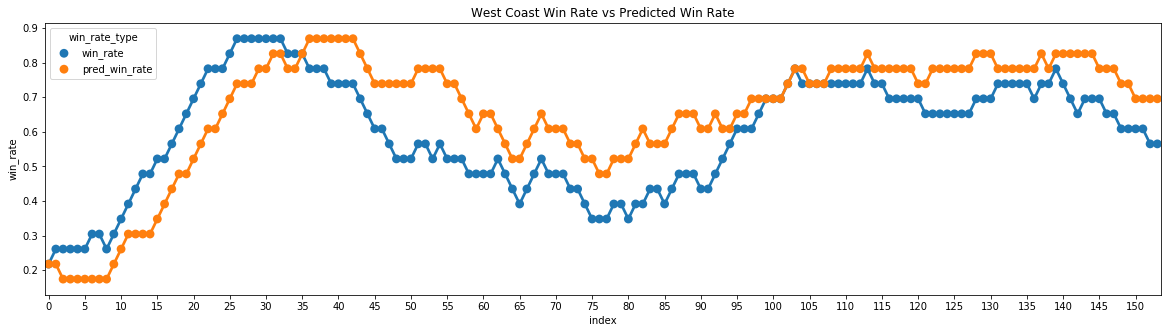

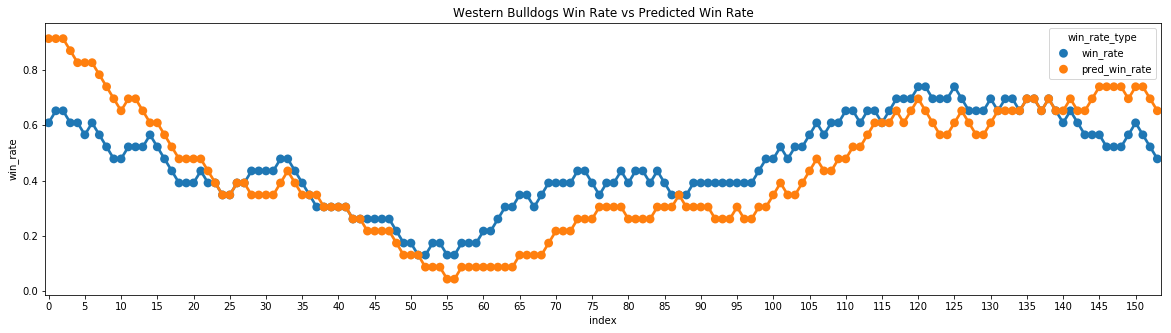

In [7]:
# Chart relationship between win rate and predicted win rate over time

for team in team_list:
    team_df = rolling_df.xs(team, level=0).reset_index(drop=True)
    win_rate_dict = {'win_rate': team_df['rolling_win_rate_23'].append(team_df['rolling_pred_win_rate_23']),
                     'win_rate_type': ['win_rate'] * len(team_df) + ['pred_win_rate'] * len(team_df)}
    win_rate_df = pd.DataFrame(win_rate_dict).reset_index()

    plt.figure(figsize=(20,5))
    ax = sns.pointplot(x='index', y='win_rate', hue='win_rate_type', data=win_rate_df, ci=None)
    plt.title('{} Win Rate vs Predicted Win Rate'.format(team))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

    plt.show()

3 patterns:

1. Teams whose win rate changes a lot: betting odds trail the actual win rate trend by 5-15 rounds, crossing the win rate at peaks and valleys. Ex: Adelaide, Geelong, Richmond, Western Bulldogs.

2. Teams that are consistently good with long periods of flatish win rates: betting odds consistently overestimate their win rates. Ex: Hawthorn, Sydney, Collingwood.

3. Teams that are consistently bad with long periods of flatish win rates: betting odds consistently underestimate their win rates. Ex: Brisbane, Carlton (recent), GWS (early).

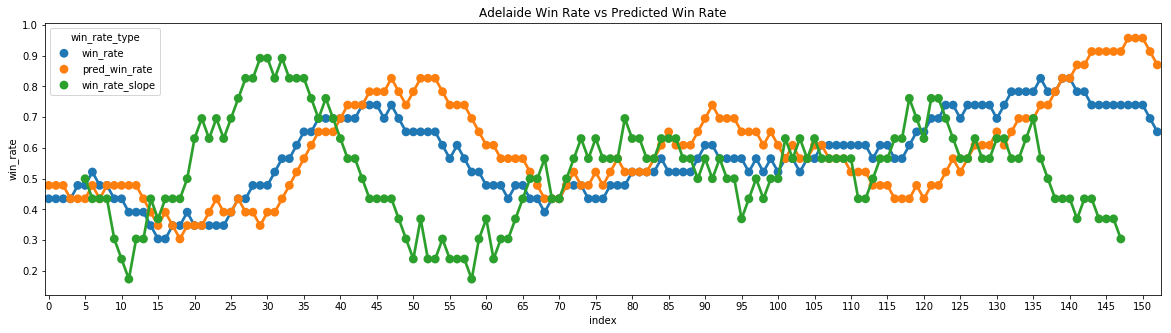

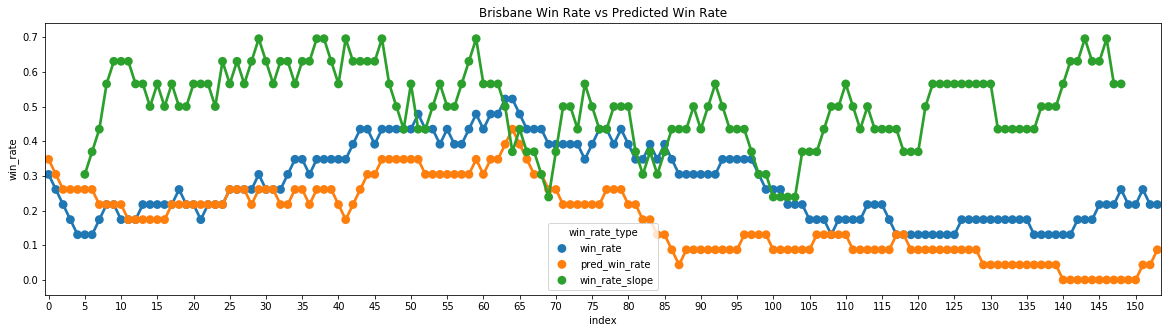

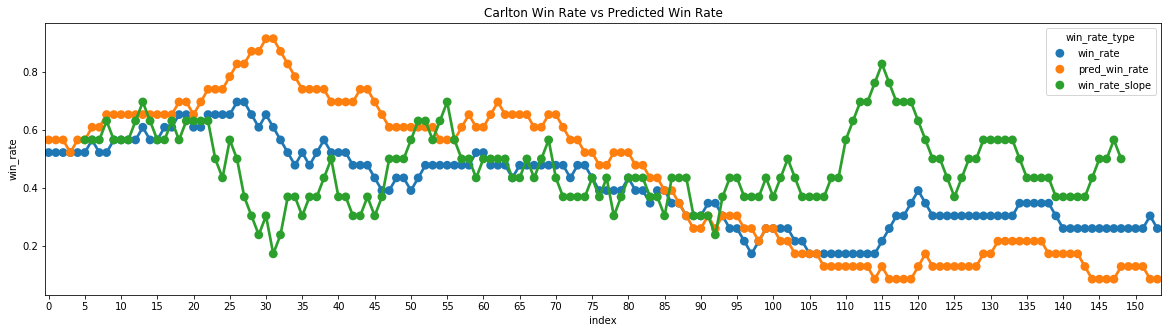

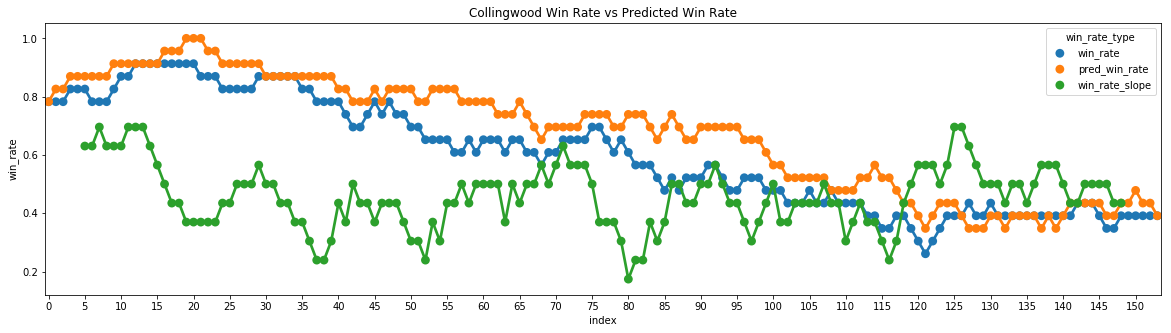

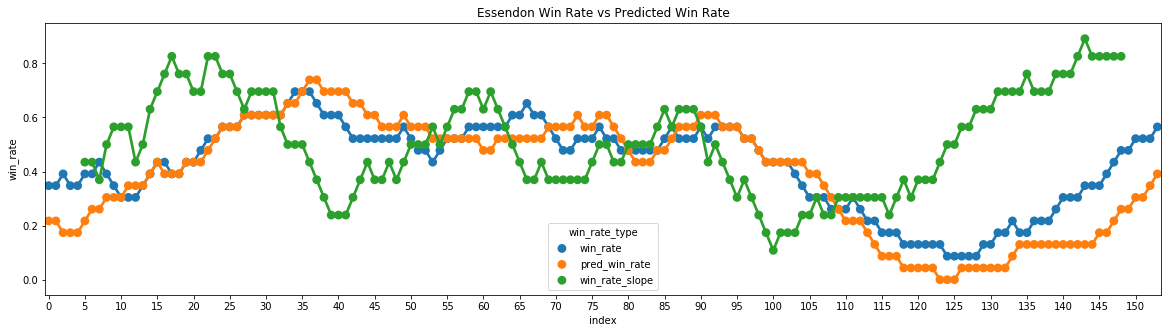

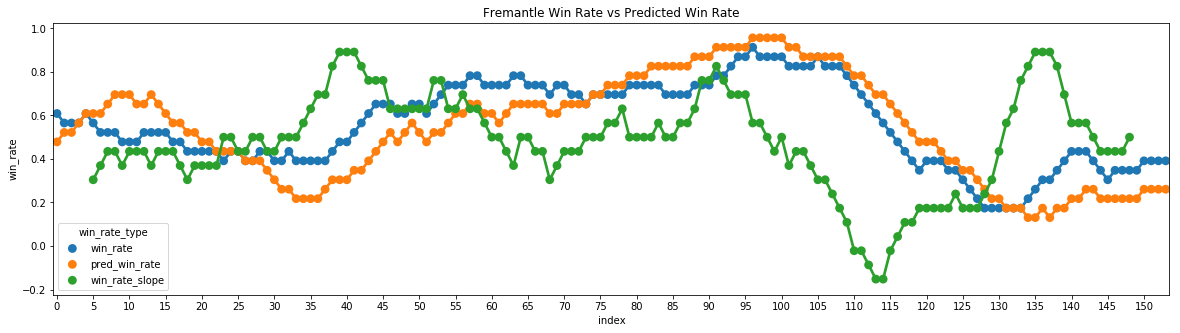

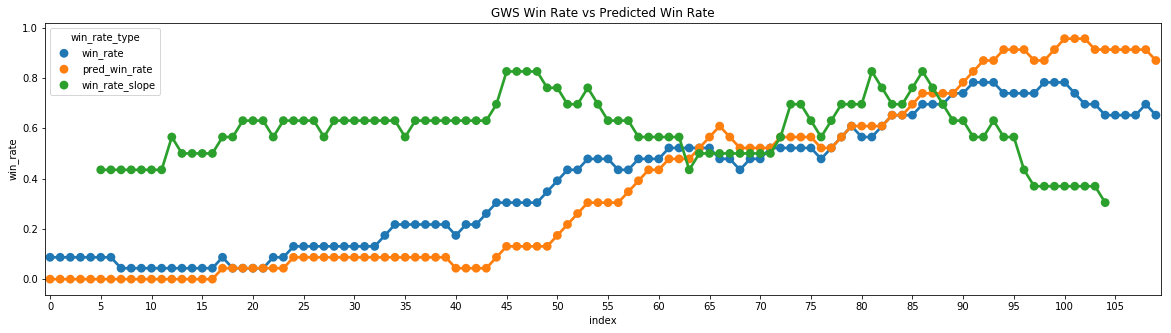

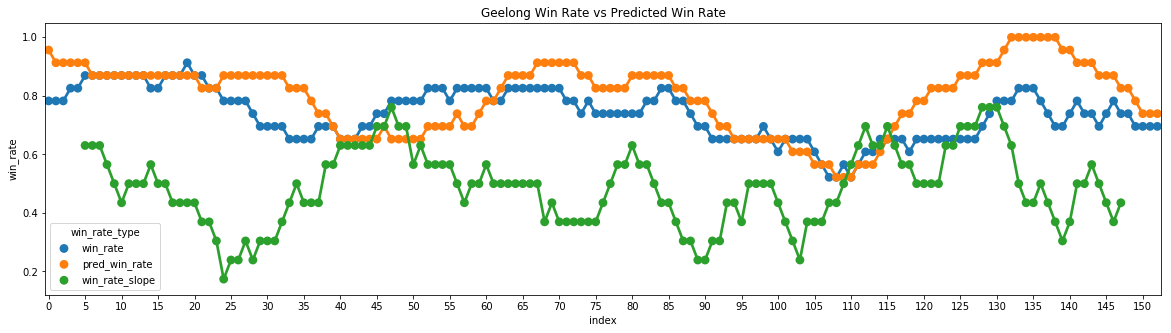

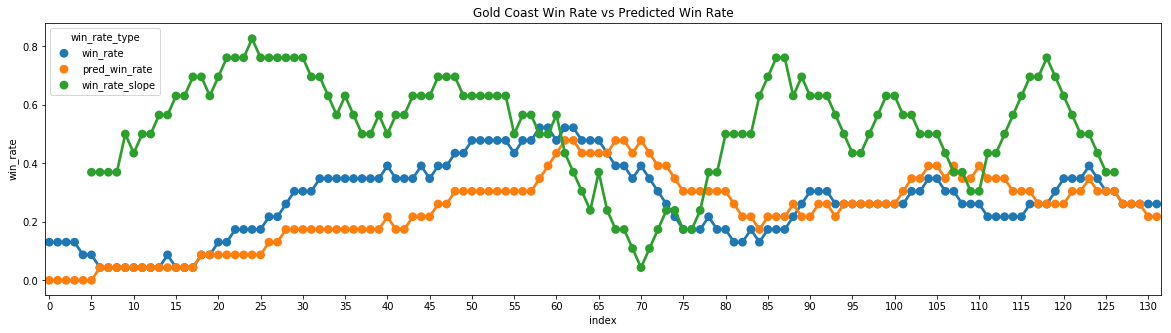

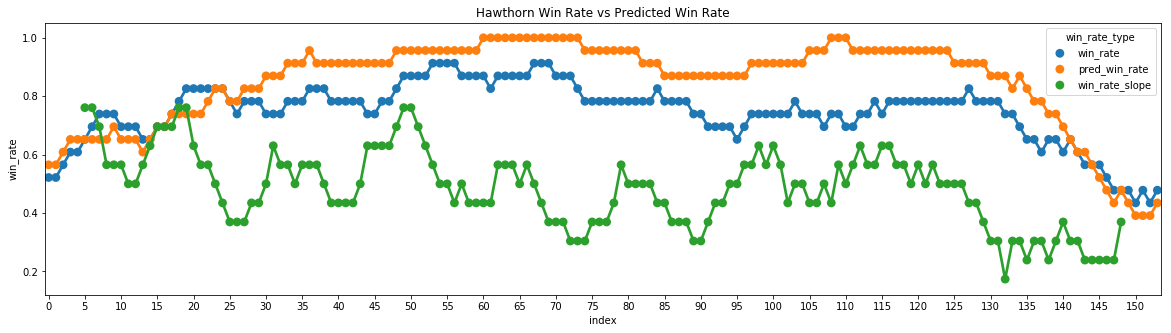

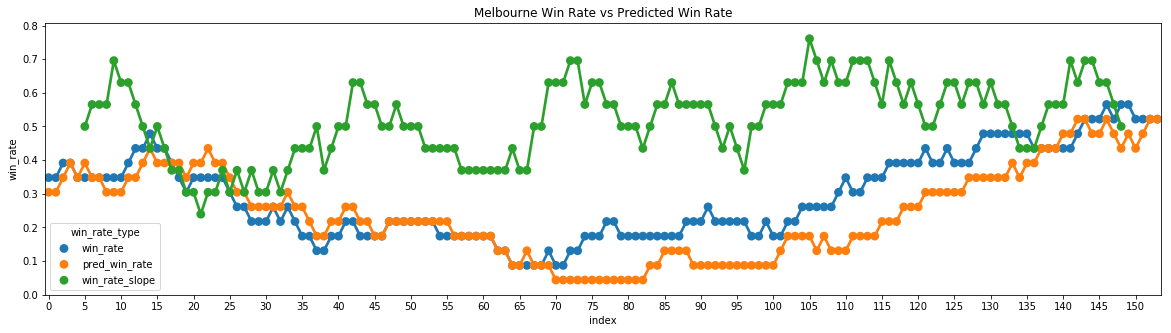

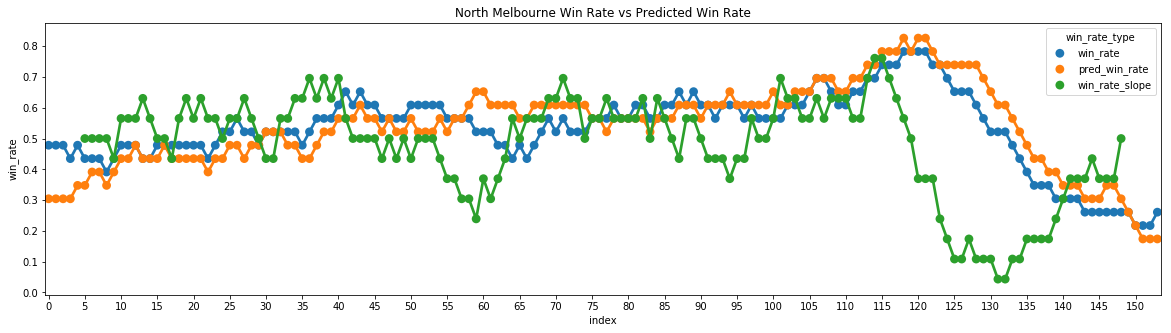

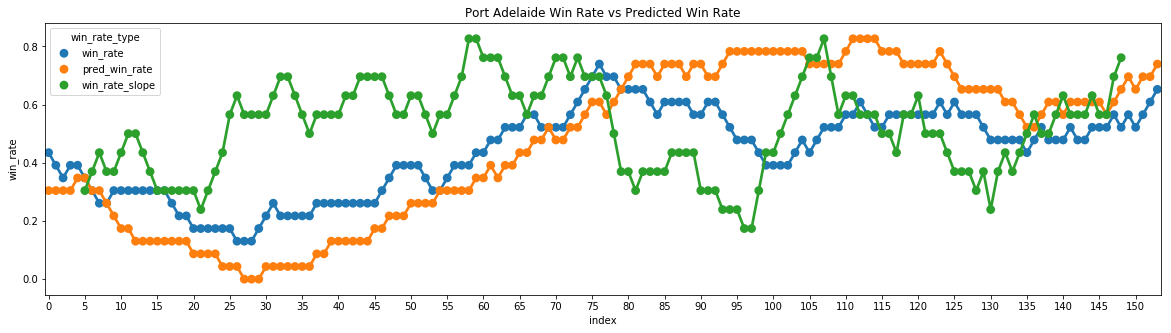

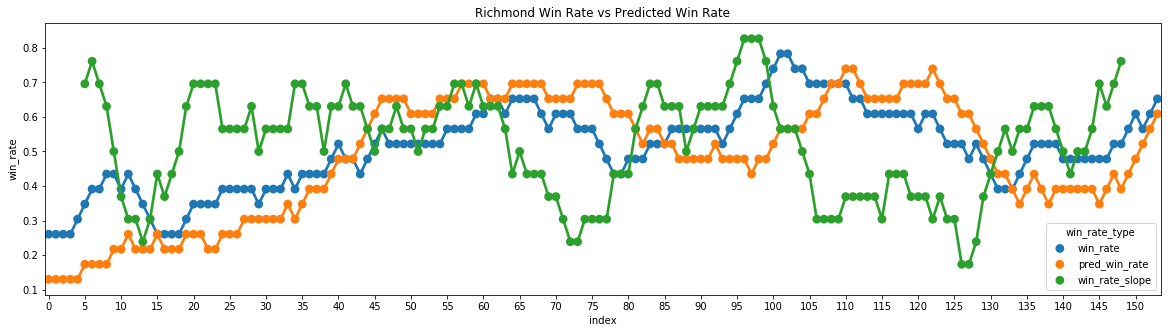

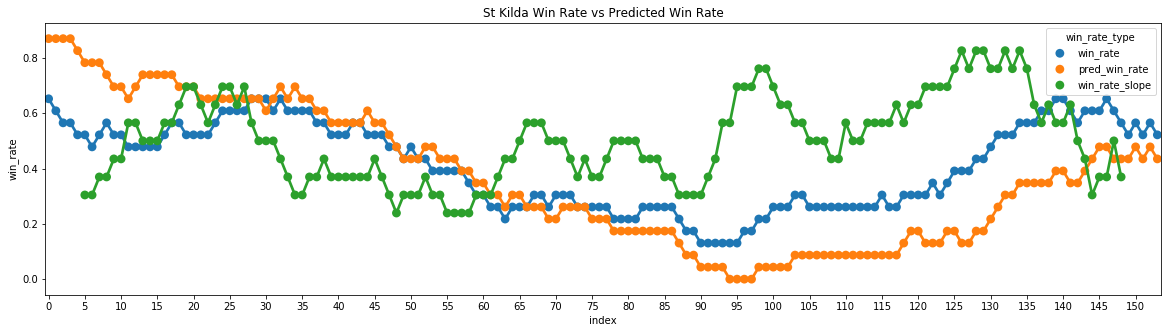

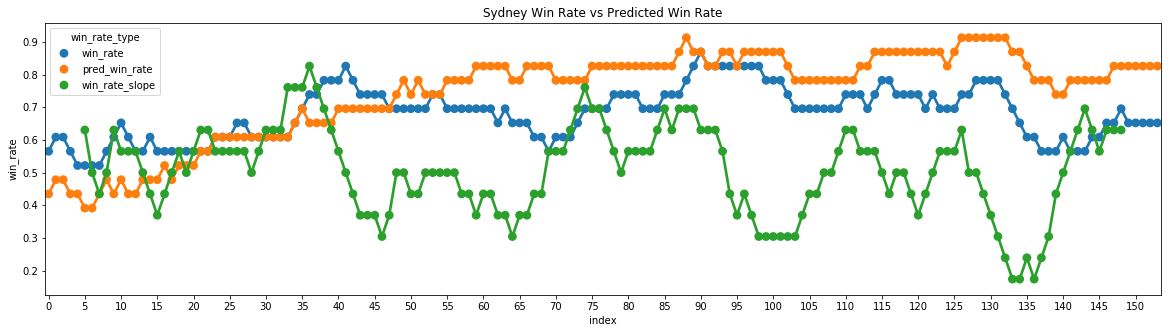

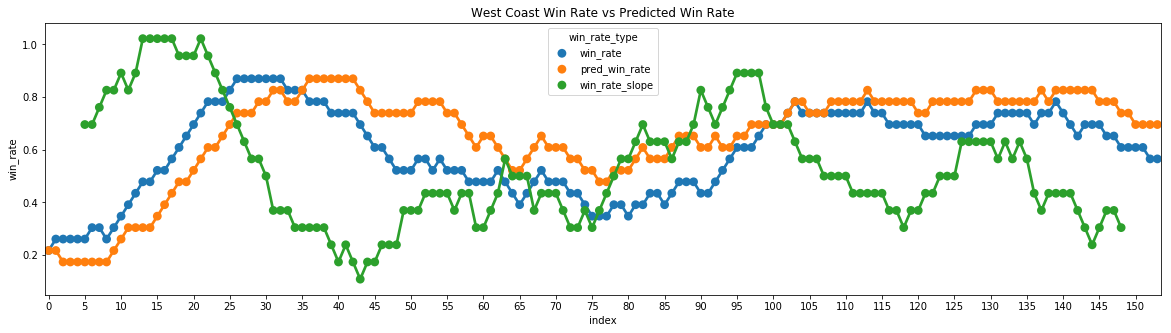

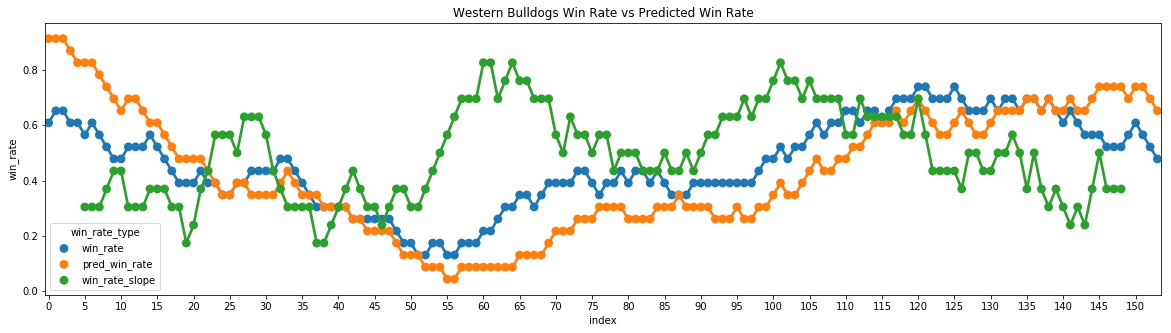

In [9]:
# Chart relationship between win rate and predicted win rate over time with the real win rate's slope added

for team in team_list:
    team_df = rolling_df.xs(team, level=0).reset_index(drop=True)
    # Setting slope at point x per change in y from x - 5 to x + 5,
    # then multiplying by 15 to account for smaller scale of y and add 0.5 to center it near the win rates
    win_rate_slope = [(team_df['rolling_win_rate_23'][idx + 5] -
                       team_df['rolling_win_rate_23'][idx - 5]) * 1.5 + 0.5
                      for idx, _
                      in team_df['rolling_win_rate_23'][5:len(team_df) - 5].iteritems()]
    team_df.loc[:, 'win_rate_slope'] = [np.nan] * 5 + win_rate_slope + [np.nan] * 5

    win_rate_dict = {'win_rate': team_df['rolling_win_rate_23'].append([team_df['rolling_pred_win_rate_23'],
                                                                        team_df['win_rate_slope']]),
                     'win_rate_type': (['win_rate'] * len(team_df) +
                                       ['pred_win_rate'] * len(team_df) +
                                       ['win_rate_slope'] * len(team_df))
                    }
    win_rate_df = pd.DataFrame(win_rate_dict).reset_index()

    plt.figure(figsize=(20,5))
    ax = sns.pointplot(x='index', y='win_rate', hue='win_rate_type', data=win_rate_df, ci=None)
    plt.title('{} Win Rate vs Predicted Win Rate'.format(team))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

    plt.show()

It's difficult to quantify the relationship between real win rate and the betting odds' predicted win rate, but combining those two stats with the slope of the real win rate could indicate to a machine learning algorithm when the odds are likely to over- or under-estimate a team's chances.

It's also possible that a model would also need a measure of a team's overall dynamism (i.e. does their win rate rise and fall from season to season or is it relatively flat for multiple seasons?) to correctly account for betting odds' biases, but I'll hold off on testing that until I start working with ML algorithms.

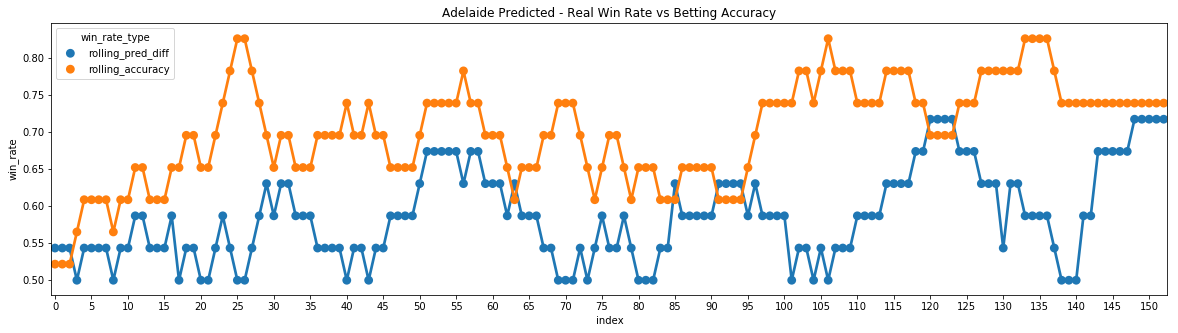

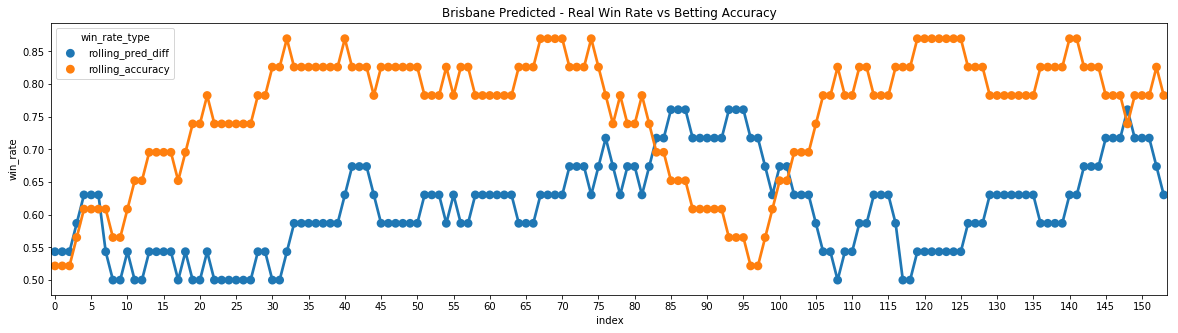

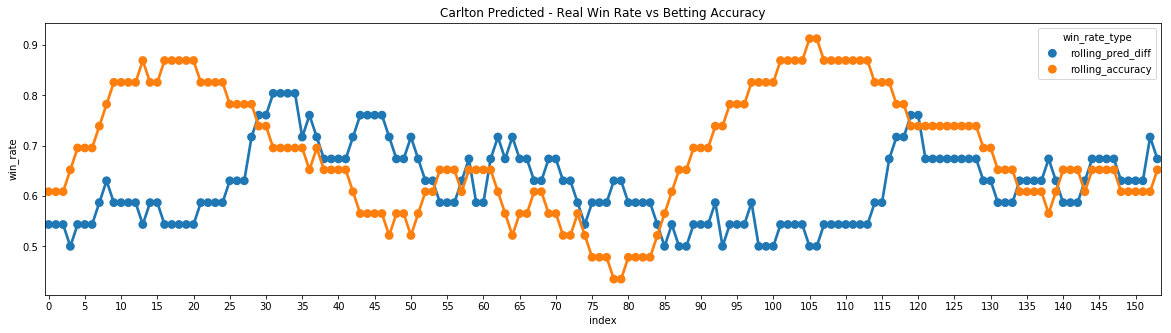

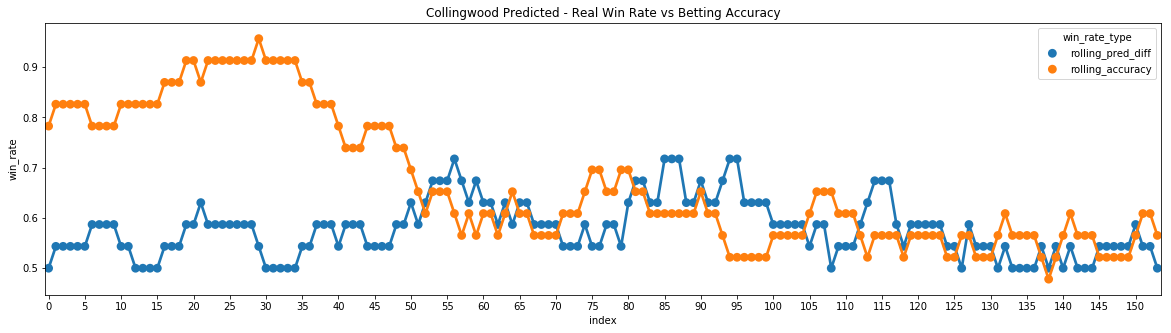

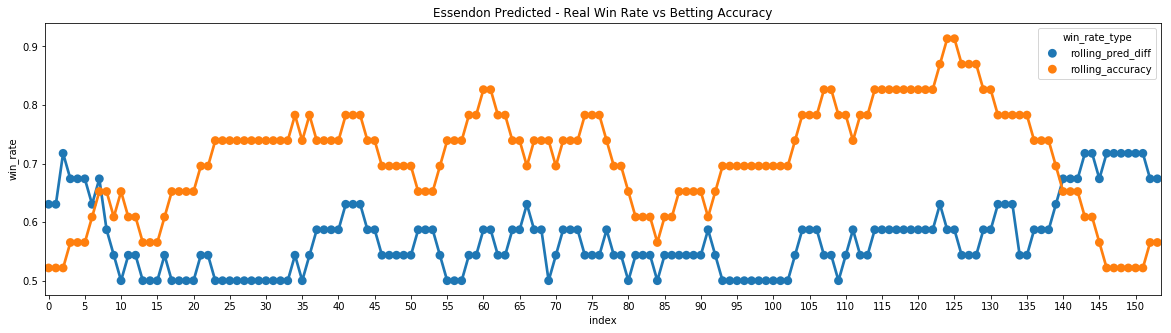

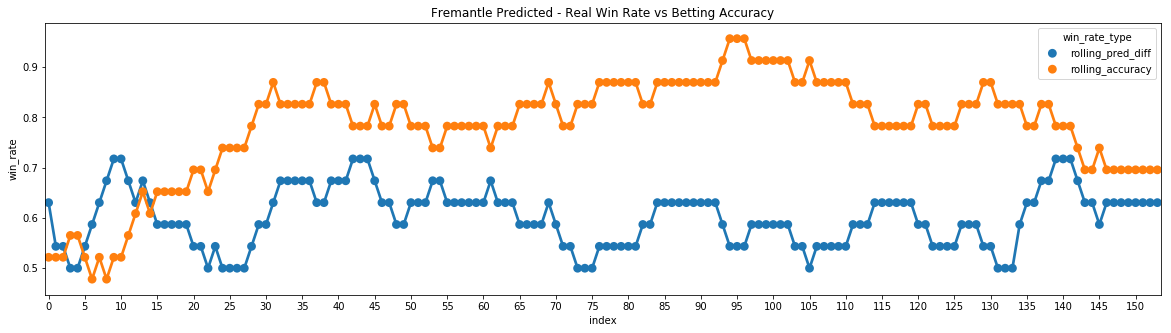

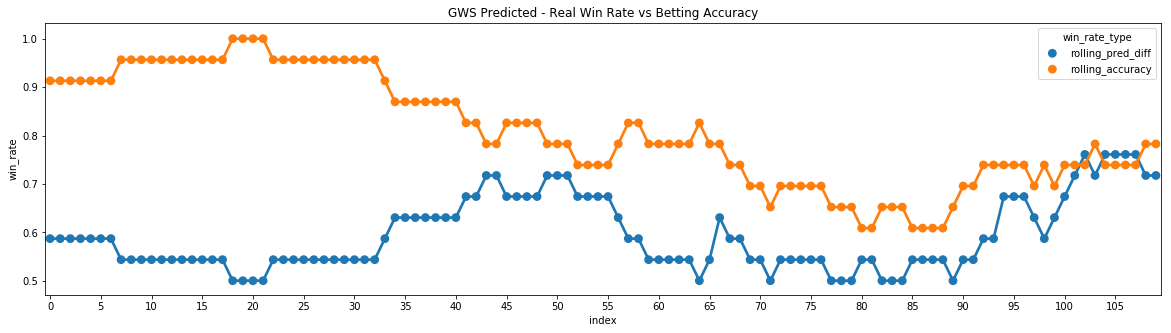

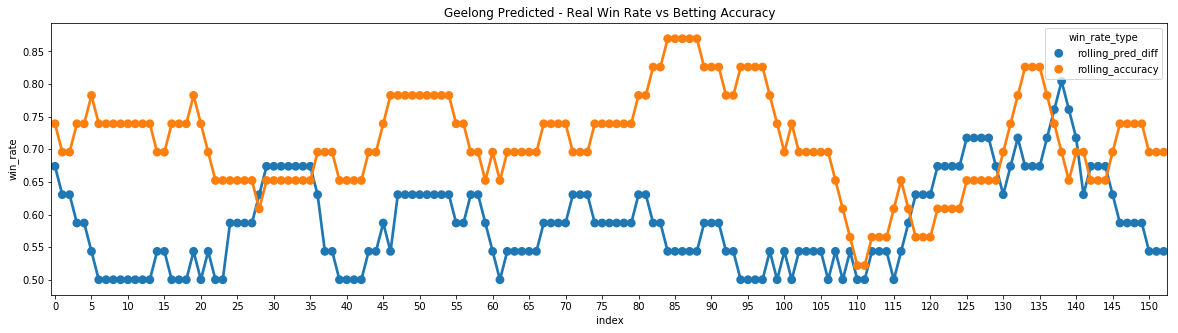

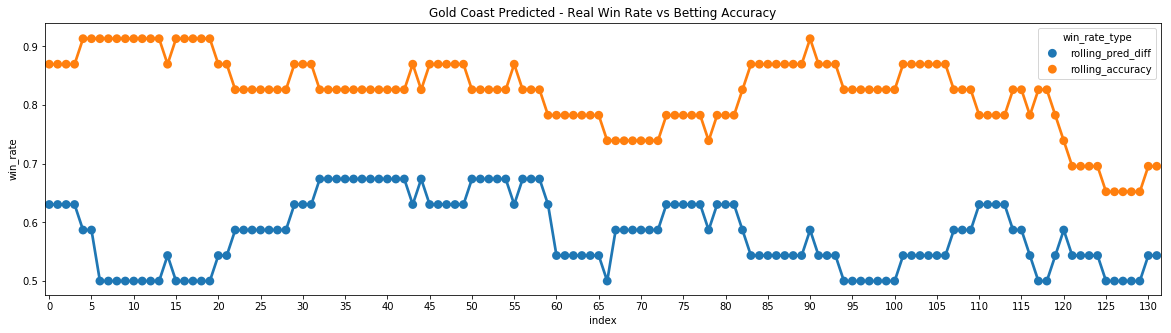

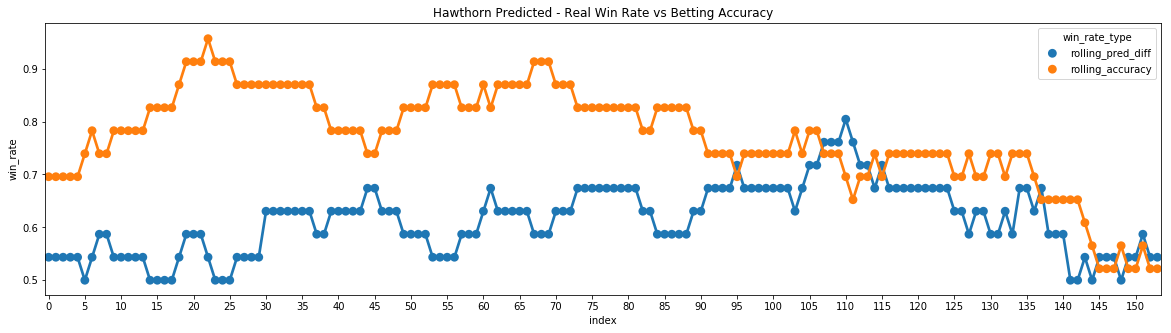

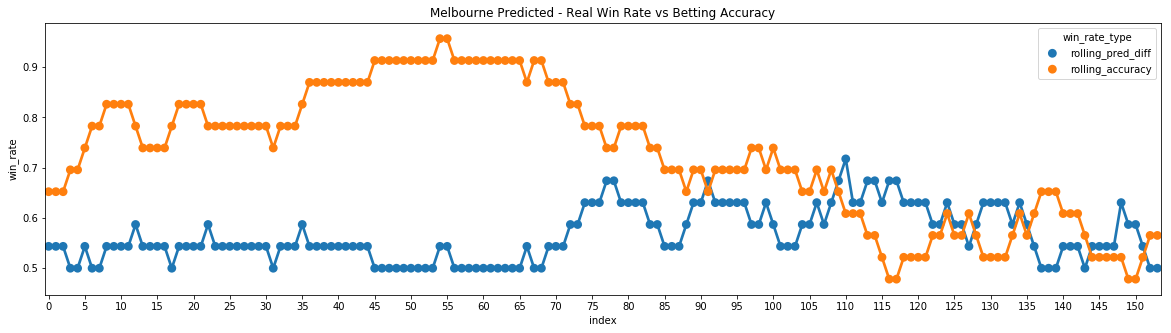

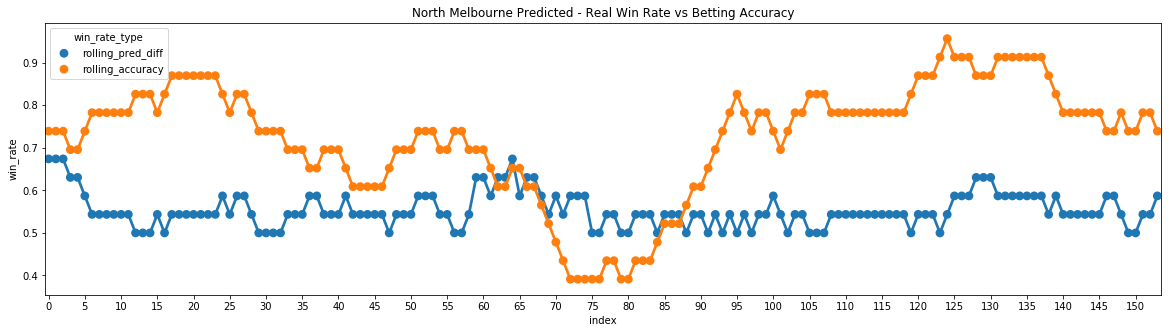

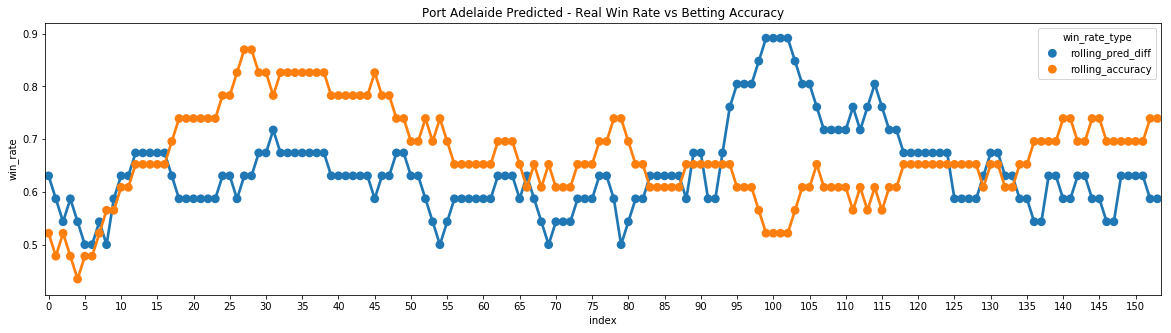

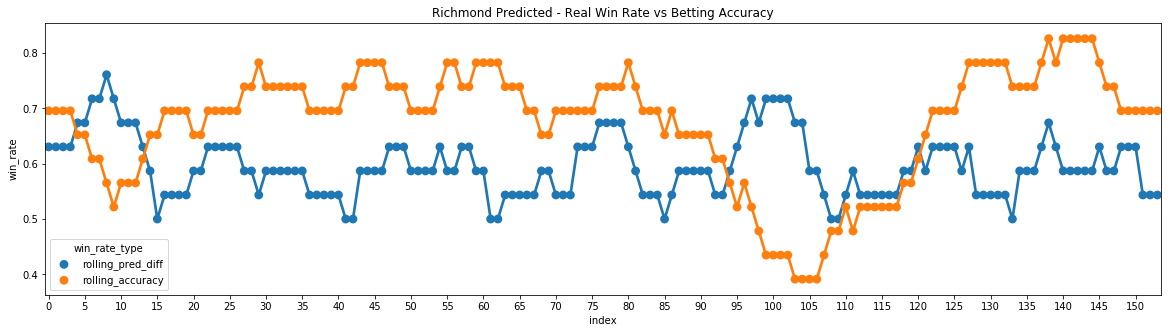

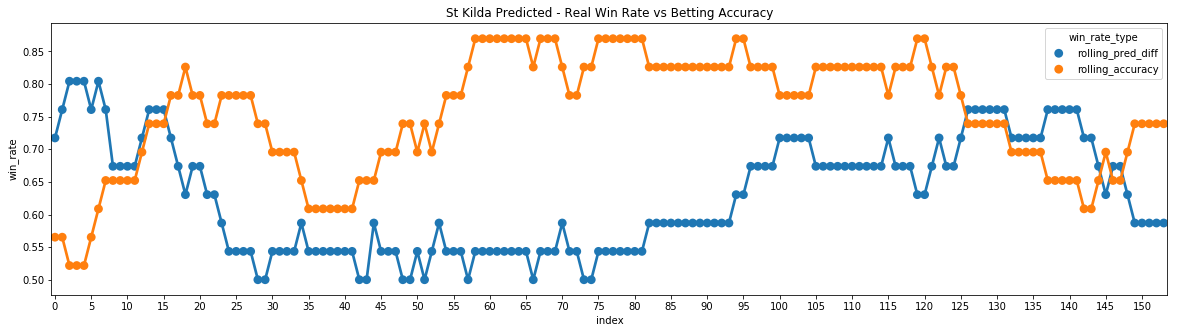

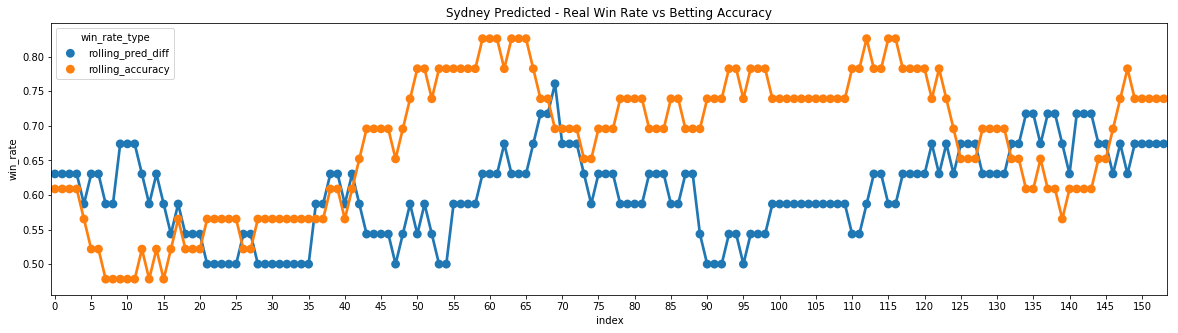

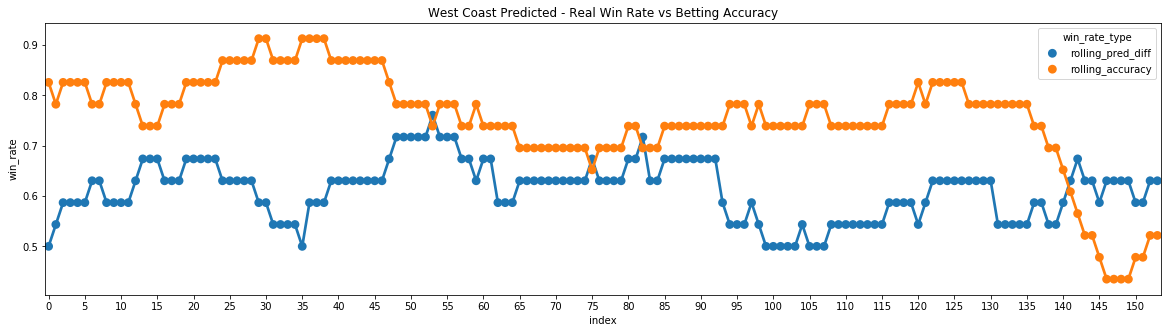

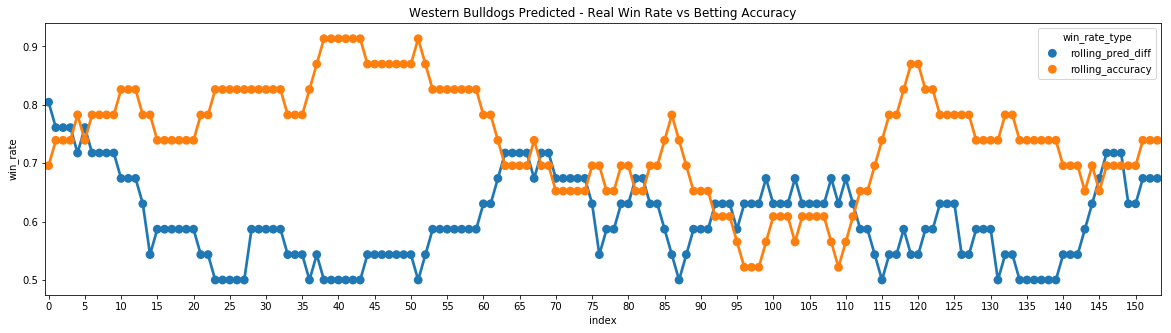

In [10]:
# Prediction error vs betting accuracy

for team in team_list:
    team_df = rolling_df.xs(team, level=0).reset_index(drop=True)
        
    # Centering pred diff at 0.5 to make it fit better with accuracy
    win_rate_dict = {'win_rate': (team_df['rolling_abs_pred_diff_23'] + 0.5).append(team_df['rolling_accuracy_23']),
                     'win_rate_type': ['rolling_pred_diff'] * len(team_df) + ['rolling_accuracy'] * len(team_df)}
    win_rate_df = pd.DataFrame(win_rate_dict).reset_index()

    plt.figure(figsize=(20,5))
    ax = sns.pointplot(x='index', y='win_rate', hue='win_rate_type', data=win_rate_df, ci=None)
    plt.title('{} Predicted - Real Win Rate vs Betting Accuracy'.format(team))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

    plt.show()

Betting accuracy looks to be negatively correlated with the absolute value of predicted win rate minus real win rate, which makes sense, but it's hard to say if this is any more useful than just using the rolling accuracy of betting odds.

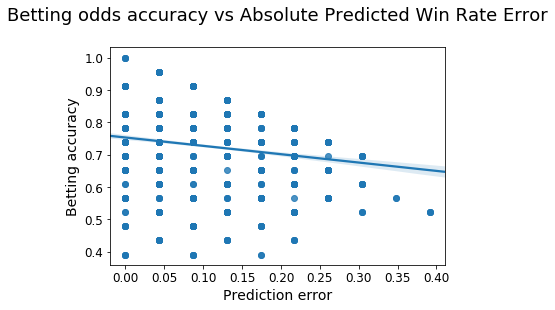

In [11]:
sns.regplot(x='rolling_abs_pred_diff_23', y='rolling_accuracy_23', data=rolling_df.reset_index(drop=True))

plt.title('Betting odds accuracy vs Absolute Predicted Win Rate Error\n', fontsize=18)
plt.ylabel('Betting accuracy', fontsize=14)
plt.xlabel('Prediction error', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

plt.show()

There is a weak relationship between betting odds' biases (time lag, general over- or underestimating certain teams) and their prediction accuracy, but the plot is too noisy to say anything with confidence.

## Correlation between past performance and future wins

In [13]:
# Create DF of wins by week, structured as t-0 (this week), t-1, t-2, ..., t-n

win_series = (betting_df['win'] + (betting_df['draw'] * 0.5)).rename('win')
time_series_cols = []

for n in range(23):
    win_col = win_series.groupby(level=0).shift(n).rename('win_{}'.format(n))
    time_series_cols.append(win_col)

time_series_df = pd.concat(time_series_cols, axis=1).dropna()
time_series_df

win_0  win_1  win_2  win_3  win_4  win_5  \
team             year round_number                                             
Adelaide         2011 1               1.0    1.0    0.0    1.0    0.0    0.0   
                      3               0.0    1.0    1.0    0.0    1.0    0.0   
                      4               0.0    0.0    1.0    1.0    0.0    1.0   
                      5               0.0    0.0    0.0    1.0    1.0    0.0   
                      6               1.0    0.0    0.0    0.0    1.0    1.0   
                      7               0.0    1.0    0.0    0.0    0.0    1.0   
                      8               1.0    0.0    1.0    0.0    0.0    0.0   
                      9               0.0    1.0    0.0    1.0    0.0    0.0   
                      10              0.0    0.0    1.0    0.0    1.0    0.0   
                      11              0.0    0.0    0.0    1.0    0.0    1.0   
                      12              0.0    0.0    0.0    0.0    1.0    0.0   
                      13              0.0    0.0    0.0    0.0    0.0    1.0   
                      14              0.0    0.0    0.0    0.0    0.0    0.0   
                      15              1.0    0.0    0.0    0.0    0.0    0.0   
                      17              0.0    1.0    0.0    0.0    0.0    0.0   
                      18              0.0    0.0    1.0    0.0    0.0    0.0   
                      19              1.0    0.0    0.0    1.0    0.0    0.0   
                      20              1.0    1.0    0.0    0.0    1.0    0.0   
                      21              0.0    1.0    1.0    0.0    0.0    1.0   
                      22              1.0    0.0    1.0    1.0    0.0    0.0   
                      23              0.0    1.0    0.0    1.0    1.0    0.0   
                      24              0.0    0.0    1.0    0.0    1.0    1.0   
                 2012 1               1.0    0.0    0.0    1.0    0.0    1.0   
                      2               1.0    1.0    0.0    0.0    1.0    0.0   
                      3               0.0    1.0    1.0    0.0    0.0    1.0   
                      4               1.0    0.0    1.0    1.0    0.0    0.0   
                      5               1.0    1.0    0.0    1.0    1.0    0.0   
                      6               1.0    1.0    1.0    0.0    1.0    1.0   
                      7               1.0    1.0    1.0    1.0    0.0    1.0   
                      8               1.0    1.0    1.0    1.0    1.0    0.0   
...                                   ...    ...    ...    ...    ...    ...   
Western Bulldogs 2016 16              1.0    1.0    0.0    1.0    1.0    1.0   
                      17              1.0    1.0    1.0    0.0    1.0    1.0   
                      18              0.0    1.0    1.0    1.0    0.0    1.0   
                      19              0.0    0.0    1.0    1.0    1.0    0.0   
                      20              1.0    0.0    0.0    1.0    1.0    1.0   
                      21              1.0    1.0    0.0    0.0    1.0    1.0   
                      22              1.0    1.0    1.0    0.0    0.0    1.0   
                      23              0.0    1.0    1.0    1.0    0.0    0.0   
                 2017 1               1.0    0.0    1.0    1.0    1.0    0.0   
                      2               1.0    1.0    0.0    1.0    1.0    1.0   
                      3               0.0    1.0    1.0    0.0    1.0    1.0   
                      4               1.0    0.0    1.0    1.0    0.0    1.0   
                      5               1.0    1.0    0.0    1.0    1.0    0.0   
                      6               0.0    1.0    1.0    0.0    1.0    1.0   
                      7               1.0    0.0    1.0    1.0    0.0    1.0   
                      8               0.0    1.0    0.0    1.0    1.0    0.0   
                      9               0.0    0.0    1.0    0.0    1.0    1.0   
                      10            

In [14]:
# For winners this week, how many won the week before, how many the week before that, etc.
time_series_df[time_series_df['win_0'] == 1].mean()

win_0     1.000000
win_1     0.559647
win_2     0.565169
win_3     0.584683
win_4     0.575479
win_5     0.562224
win_6     0.562224
win_7     0.563328
win_8     0.565169
win_9     0.558542
win_10    0.558910
win_11    0.571060
win_12    0.574742
win_13    0.564433
win_14    0.561119
win_15    0.562592
win_16    0.570692
win_17    0.558542
win_18    0.543814
win_19    0.568115
win_20    0.555596
win_21    0.526510
win_22    0.564433
dtype: float64

In [15]:
time_series_df[time_series_df['win_0'] == 1].mean().drop('win_0').mean()

0.56259204712812982

In [16]:
# For losers this week, how many won the week before, how many the week before that, etc.
time_series_df[time_series_df['win_0'] == 0].mean()

win_0     0.000000
win_1     0.450529
win_2     0.444486
win_3     0.422205
win_4     0.431647
win_5     0.445997
win_6     0.445242
win_7     0.443731
win_8     0.441465
win_9     0.445242
win_10    0.447130
win_11    0.434290
win_12    0.425604
win_13    0.437689
win_14    0.439577
win_15    0.437311
win_16    0.431269
win_17    0.444486
win_18    0.457326
win_19    0.430136
win_20    0.444486
win_21    0.473565
win_22    0.434668
dtype: float64

In [17]:
time_series_df[time_series_df['win_0'] == 0].mean().drop('win_0').mean()

0.44127643504531716

No obvious relatioship between this week's results and previous weeks beyond the fact that teams that win in any given week tend to win in any other given week (~56%) and same for losers (~44%).

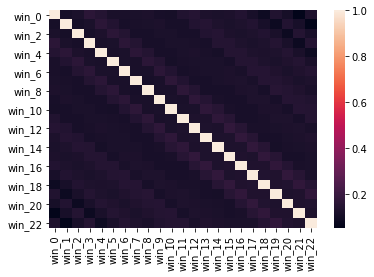

In [18]:
# Calculate correlation among wins across time

corr_df = time_series_df.corr()
sns.heatmap(corr_df)
plt.show()

In [19]:
corr_df

win_0     win_1     win_2     win_3     win_4     win_5     win_6  \
win_0   1.000000  0.109113  0.120682  0.162456  0.143819  0.116181  0.116978   
win_1   0.109113  1.000000  0.110621  0.122188  0.162470  0.140789  0.115492   
win_2   0.120682  0.110621  1.000000  0.113618  0.123694  0.161669  0.142346   
win_3   0.162456  0.122188  0.113618  1.000000  0.116615  0.120672  0.163234   
win_4   0.143819  0.162470  0.123694  0.116615  1.000000  0.115833  0.119984   
win_5   0.116181  0.140789  0.161669  0.120672  0.115833  1.000000  0.119567   
win_6   0.116978  0.115492  0.142346  0.163234  0.119984  0.119567  1.000000   
win_7   0.119597  0.116992  0.115505  0.142359  0.161754  0.116218  0.115894   
win_8   0.123653  0.119558  0.113971  0.114722  0.142310  0.163869  0.116969   
win_9   0.113182  0.124365  0.121016  0.115432  0.113946  0.142211  0.163879   
win_10  0.111701  0.114685  0.121396  0.119537  0.115443  0.111675  0.140784   
win_11  0.136717  0.113983  0.114732  0.121446  0.121822  0.117678  0.112508   
win_12  0.149026  0.139711  0.115485  0.119216  0.124438  0.120293  0.117732   
win_13  0.126688  0.147563  0.141228  0.115511  0.119240  0.120686  0.120360   
win_14  0.121469  0.127435  0.146819  0.141975  0.111785  0.120686  0.122969   
win_15  0.125206  0.121480  0.125954  0.145337  0.141984  0.112496  0.124467   
win_16  0.139370  0.127444  0.122226  0.129682  0.144593  0.144912  0.116266   
win_17  0.114024  0.141608  0.129681  0.122973  0.130429  0.144539  0.147949   
win_18  0.086449  0.115524  0.141617  0.129690  0.124472  0.128897  0.146091   
win_19  0.137889  0.085705  0.117761  0.143854  0.130436  0.120700  0.131928   
win_20  0.111060  0.140880  0.085714  0.117770  0.145352  0.131139  0.122988   
win_21  0.052921  0.112560  0.142379  0.085722  0.119268  0.143815  0.131941   
win_22  0.129716  0.052930  0.115549  0.143877  0.087220  0.117740  0.143875   

           win_7     win_8     win_9    ...       win_13    win_14    win_15  \
win_0   0.119597  0.123653  0.113182    ...     0.126688  0.121469  0.125206   
win_1   0.116992  0.119558  0.124365    ...     0.147563  0.127435  0.121480   
win_2   0.115505  0.113971  0.121016    ...     0.141228  0.146819  0.125954   
win_3   0.142359  0.114722  0.115432    ...     0.115511  0.141975  0.145337   
win_4   0.161754  0.142310  0.113946    ...     0.119240  0.111785  0.141984   
win_5   0.116218  0.163869  0.142211    ...     0.120686  0.120686  0.112496   
win_6   0.115894  0.116969  0.163879    ...     0.120360  0.122969  0.124467   
win_7   1.000000  0.115111  0.117681    ...     0.114771  0.119617  0.125959   
win_8   0.115111  1.000000  0.116893    ...     0.114728  0.113983  0.114362   
win_9   0.117681  0.116893  1.000000    ...     0.148208  0.118412  0.114693   
win_10  0.166870  0.116898  0.119837    ...     0.168323  0.151935  0.116929   
win_11  0.140840  0.166870  0.118392    ...     0.123675  0.170621  0.150506   
win_12  0.115500  0.143774  0.169796    ...     0.127403  0.124422  0.175098   
win_13  0.114771  0.114728  0.148208    ...     1.000000  0.129645  0.127412   
win_14  0.119617  0.113983  0.118412    ...     0.129645  1.000000  0.130393   
win_15  0.125959  0.114362  0.114693    ...     0.127412  0.130393  1.000000   
win_16  0.128195  0.126657  0.115065    ...     0.175848  0.128903  0.131140   
win_17  0.117013  0.128893  0.128101    ...     0.152003  0.175848  0.128159   
win_18  0.147956  0.114740  0.128851    ...     0.112511  0.149770  0.175852   
win_19  0.143856  0.150136  0.112464    ...     0.115492  0.111021  0.150516   
win_20  0.133425  0.143808  0.147107    ...     0.120338  0.116240  0.112515   
win_21  0.120013  0.133381  0.145250    ...     0.123694  0.121086  0.114752   
win_22  0.127474  0.117739  0.137062    ...     0.132639  0.125932  0.122579   

          win_16    win_17    win_18    win_19    win_20    win_21    win_22  
win_0   0.139370  0.114024  0.086449  0.137889  0.111060  0.052921  0.129716  
win_1   0.1

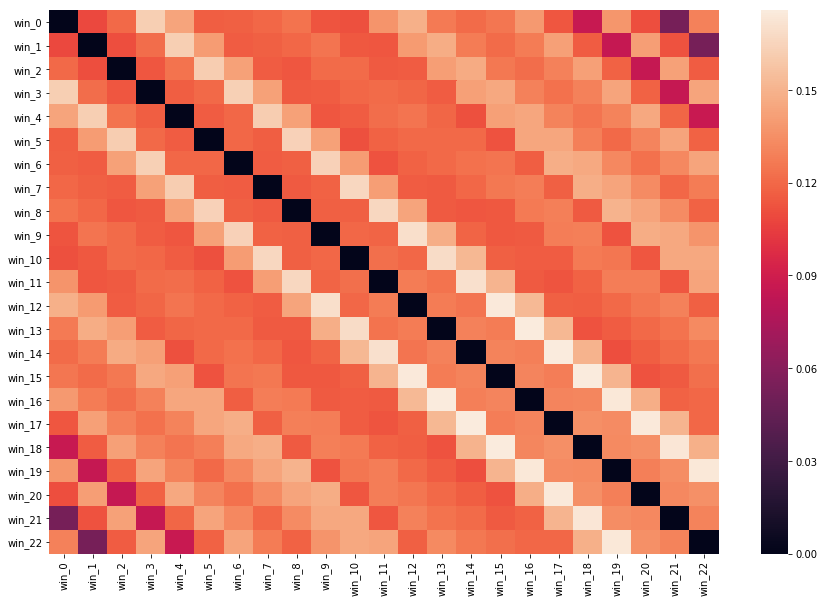

In [20]:
# Given low correlations, set diagonal to 0 to bring out the color gradient more

test_df = corr_df.copy()

for col in test_df.columns.values:
    test_df.loc[col, col] = 0

plt.figure(figsize=(15, 10))
sns.heatmap(test_df)
plt.show()

It could be a fluke, but there is a weirdly strong correlation between winning this week and winning three weeks ago.

In [23]:
score_series_cols = []

for n in range(23):
    score_col = rolling_df['score_diff'].groupby(level=0).shift(n).rename('score_diff_{}'.format(n))
    score_series_cols.append(score_col)

score_series_df = pd.concat(score_series_cols, axis=1).dropna()
score_series_df

win_0  win_1  win_2  win_3  win_4  win_5  \
team             year round_number                                             
Adelaide         2012 1              69.0  -95.0  -22.0   61.0  -11.0    5.0   
                      2              18.0   69.0  -95.0  -22.0   61.0  -11.0   
                      3             -56.0   18.0   69.0  -95.0  -22.0   61.0   
                      4              46.0  -56.0   18.0   69.0  -95.0  -22.0   
                      5              19.0   46.0  -56.0   18.0   69.0  -95.0   
                      6               5.0   19.0   46.0  -56.0   18.0   69.0   
                      7              50.0    5.0   19.0   46.0  -56.0   18.0   
                      8              69.0   50.0    5.0   19.0   46.0  -56.0   
                      9             -26.0   69.0   50.0    5.0   19.0   46.0   
                      10             29.0  -26.0   69.0   50.0    5.0   19.0   
                      12              4.0   29.0  -26.0   69.0   50.0    5.0   
                      13            -32.0    4.0   29.0  -26.0   69.0   50.0   
                      14             19.0  -32.0    4.0   29.0  -26.0   69.0   
                      15             58.0   19.0  -32.0    4.0   29.0  -26.0   
                      16            119.0   58.0   19.0  -32.0    4.0   29.0   
                      17             49.0  119.0   58.0   19.0  -32.0    4.0   
                      18            -27.0   49.0  119.0   58.0   19.0  -32.0   
                      19              4.0  -27.0   49.0  119.0   58.0   19.0   
                      20             28.0    4.0  -27.0   49.0  119.0   58.0   
                      21            -10.0   28.0    4.0  -27.0   49.0  119.0   
                      22             69.0  -10.0   28.0    4.0  -27.0   49.0   
                      23             91.0   69.0  -10.0   28.0    4.0  -27.0   
                 2013 1             -35.0   91.0   69.0  -10.0   28.0    4.0   
                      2              19.0  -35.0   91.0   69.0  -10.0   28.0   
                      3              -9.0   19.0  -35.0   91.0   69.0  -10.0   
                      4              52.0   -9.0   19.0  -35.0   91.0   69.0   
                      5             -32.0   52.0   -9.0   19.0  -35.0   91.0   
                      6             -11.0  -32.0   52.0   -9.0   19.0  -35.0   
                      7             135.0  -11.0  -32.0   52.0   -9.0   19.0   
                      8              40.0  135.0  -11.0  -32.0   52.0   -9.0   
...                                   ...    ...    ...    ...    ...    ...   
Western Bulldogs 2016 16             10.0    4.0  -57.0    3.0    8.0   21.0   
                      17             48.0   10.0    4.0  -57.0    3.0    8.0   
                      18            -15.0   48.0   10.0    4.0  -57.0    3.0   
                      19            -25.0  -15.0   48.0   10.0    4.0  -57.0   
                      20             14.0  -25.0  -15.0   48.0   10.0    4.0   
                      21              3.0   14.0  -25.0  -15.0   48.0   10.0   
                      22             40.0    3.0   14.0  -25.0  -15.0   48.0   
                      23            -20.0   40.0    3.0   14.0  -25.0  -15.0   
                 2017 1              14.0  -20.0   40.0    3.0   14.0  -25.0   
                      2              23.0   14.0  -20.0   40.0    3.0   14.0   
                      3             -16.0   23.0   14.0  -20.0   40.0    3.0   
                      4               3.0  -16.0   23.0   14.0  -20.0   40.0   
                      5              32.0    3.0  -16.0   23.0   14.0  -20.0   
                      6              -2.0   32.0    3.0  -16.0   23.0   14.0   
                      7               5.0   -2.0   32.0    3.0  -16.0   23.0   
                      8              -8.0    5.0   -2.0   32.0    3.0  -16.0   
                      9             -23.0   -8.0    5.0   -2.0   32.0    3.0   
                      10            

Correlation: 0.165092753097
Pearson R^2:  0.0272556171251


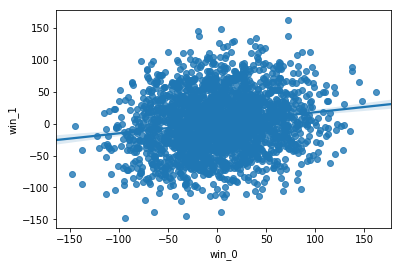

Correlation: 0.170617047201
Pearson R^2:  0.0291101767956


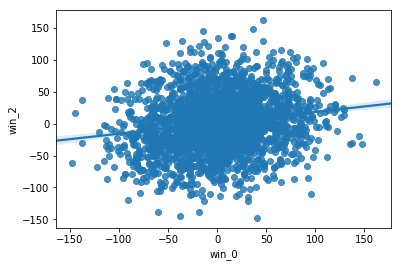

Correlation: 0.224526515221
Pearson R^2:  0.0504121560374


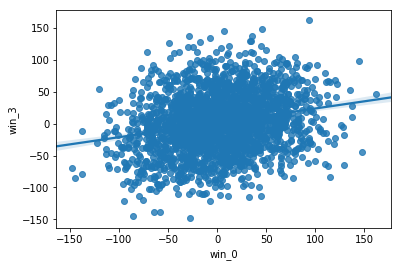

Correlation: 0.189187489288
Pearson R^2:  0.0357919061031


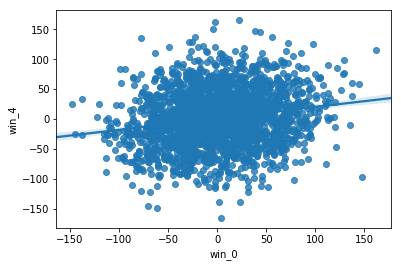

Correlation: 0.142783317669
Pearson R^2:  0.0203870758045


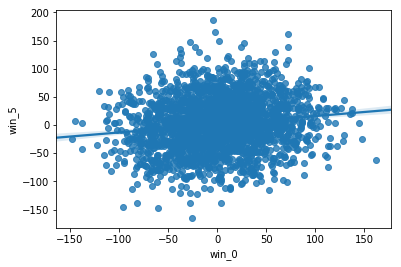

Correlation: 0.19395009573
Pearson R^2:  0.0376166396336


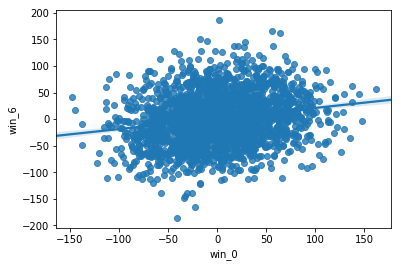

Correlation: 0.171599490232
Pearson R^2:  0.029446385048


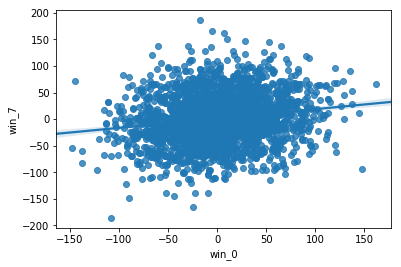

Correlation: 0.165612497616
Pearson R^2:  0.0274274993667


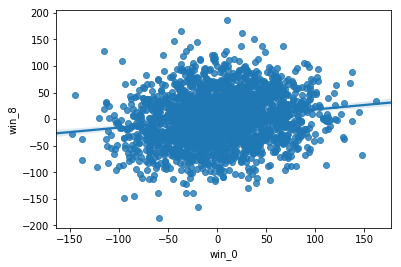

Correlation: 0.172593463823
Pearson R^2:  0.0297885037544


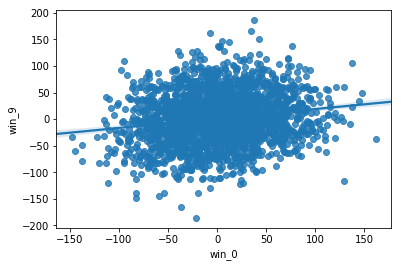

Correlation: 0.149037998181
Pearson R^2:  0.0222123249018


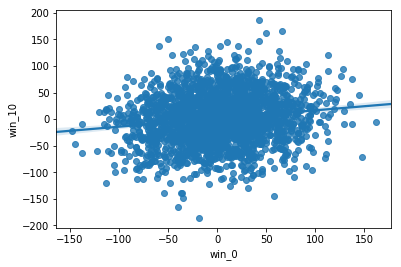

Correlation: 0.165366419946
Pearson R^2:  0.0273460528457


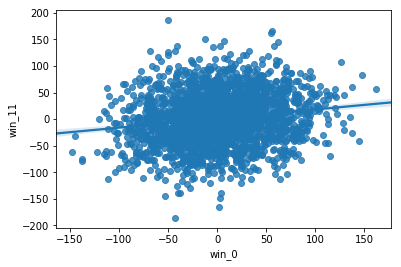

Correlation: 0.165128287763
Pearson R^2:  0.0272673514197


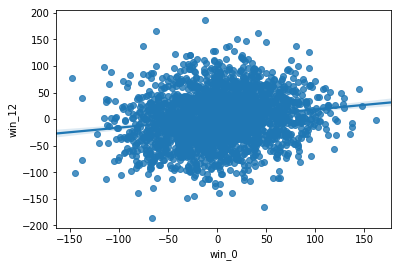

Correlation: 0.153804143719
Pearson R^2:  0.023655714625


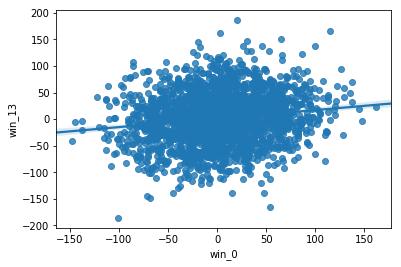

Correlation: 0.170885651936
Pearson R^2:  0.0292019060376


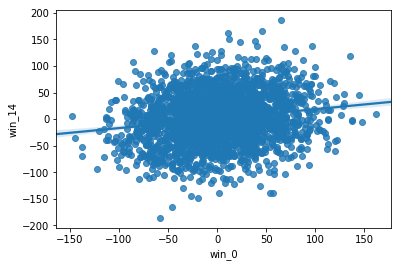

Correlation: 0.185036599069
Pearson R^2:  0.0342385429951


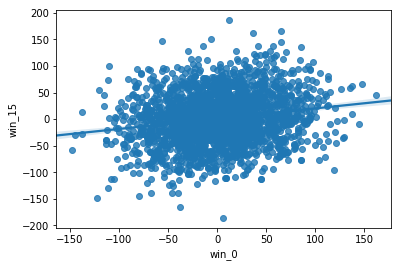

Correlation: 0.163746434261
Pearson R^2:  0.0268128947333


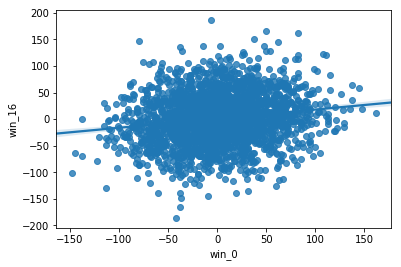

Correlation: 0.161250320117
Pearson R^2:  0.0260016657378


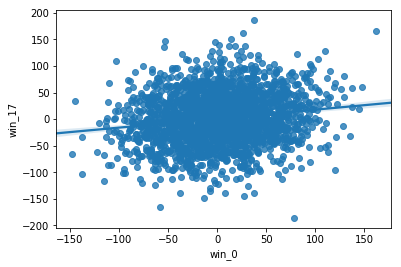

Correlation: 0.184271033217
Pearson R^2:  0.0339558136827


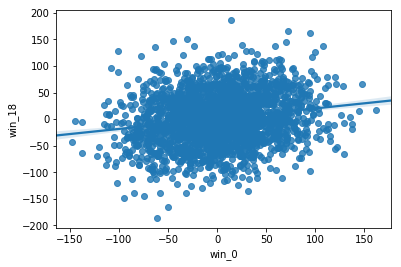

Correlation: 0.157954973121
Pearson R^2:  0.0249497735338


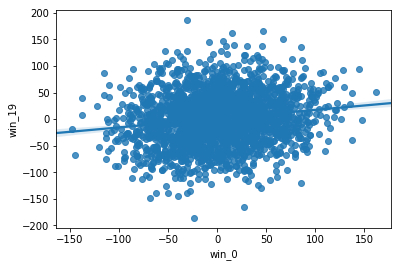

Correlation: 0.143035147619
Pearson R^2:  0.0204590534544


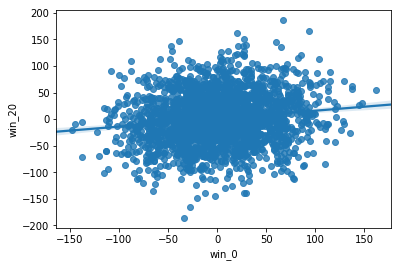

Correlation: 0.146814368068
Pearson R^2:  0.0215544586713


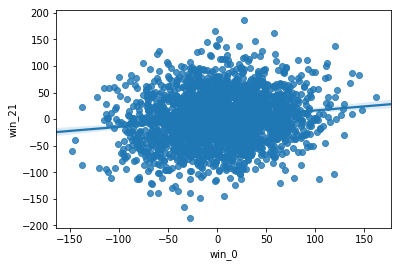

Correlation: 0.183751273346
Pearson R^2:  0.0337645304564


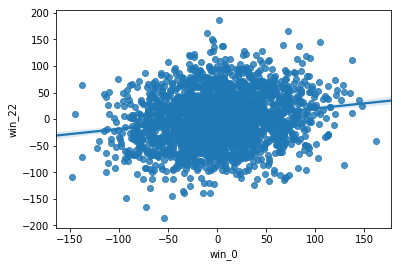

In [33]:
from scipy import stats

for n in range(1, 23):
    print('Correlation:', score_series_df[['score_diff_0', 'score_diff_{}'.format(n)]].corr().iloc[0, 1])
    print('Pearson R^2: ',
          stats.pearsonr(score_series_df['score_diff_0'], score_series_df['score_diff_{}'.format(n)])[0] ** 2)
    sns.regplot(x='score_dif_0', y='score_df_{}'.format(n), data=score_series_df)
    plt.show()